# Part I (c) Visualization of a typical model trained by ImageNet

we try to visualize what deep convolutional neural networks really learn, and how they understand the images we feed them.

We will use Keras and related extension to visualize inputs that maximize the activation of the filters in different layers of the VGG-16 architecture, trained on ImageNet.

In [1]:
from keras.applications import VGG16
from vis.utils import utils
from keras import activations
import numpy as np
from vis.visualization import visualize_activation

from matplotlib import pyplot as plt
%matplotlib inline

# Build the VGG16 network with ImageNet weights
model = VGG16(weights='imagenet', include_top=True)

Using TensorFlow backend.


# Model architecture

VGG-16 (also called OxfordNet) is a convolutional neural network architecture named after the Visual Geometry Group from Oxford, who developed it. It was used to win the ILSVR (ImageNet) competition in 2014. To this day is it still considered to be an excellent vision model, although it has been somewhat outperformed by more revent advances such as Inception and ResNet.
(Ref to https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)

In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Besides fully-connected layers, VGG-16 model has 18 layers in total, which could be divided into 5 blocks. Each block contains several filters and 1 maxpooling layer. In this report we aim to explore what filters have learned. We wish to systematically display what sort of input maximizes each filter in each layer, giving us a neat visualization of the convnet's modular-hierarchical decomposition of its visual space.

# Visualization of the first layer

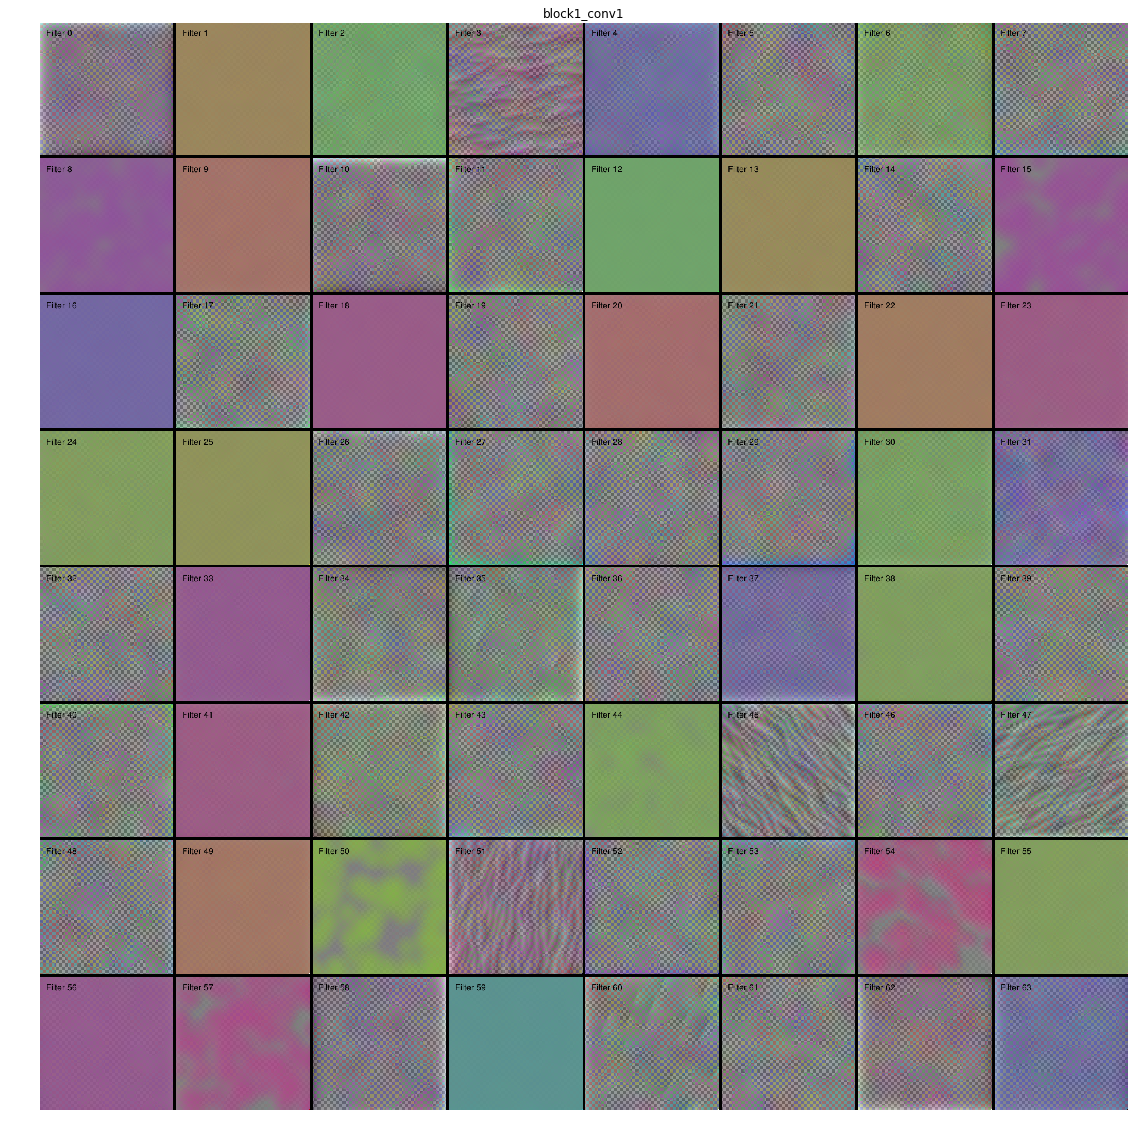

In [15]:
from vis.visualization import get_num_filters

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'block1_conv1'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

As we can see, the first layer basically just encode direction and color.
We observed that some filters in the first layer were visualized as approximately pure colors and others, which indicates that these filters were serving as color filters. Meanwhile, some other visualized filters displayed significant stripes, which means that they have learned features relating to directions.
In fact, customized VGG-16 model may learn different types of features in the first layer. Some researchers had shown that their visualization of first layer of customized VGG-16 model would only display colors.(Ref to https://lhncbc.nlm.nih.gov/publication/pub9809) 
So in general, we would make a conculusion that the first layer.

# Visualization of higher level layers

We chose to visualize 10 randomly selected filters in layers "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3".

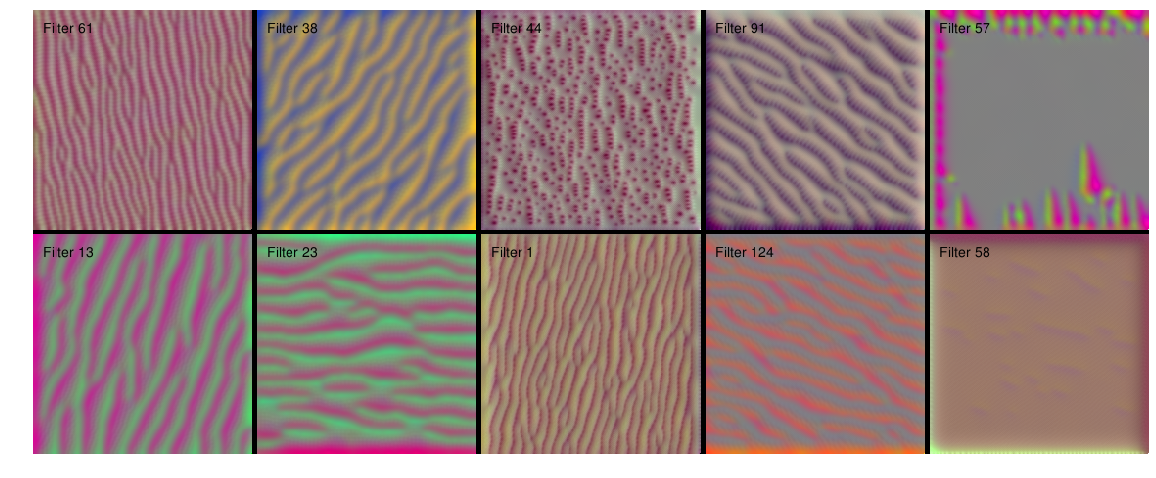

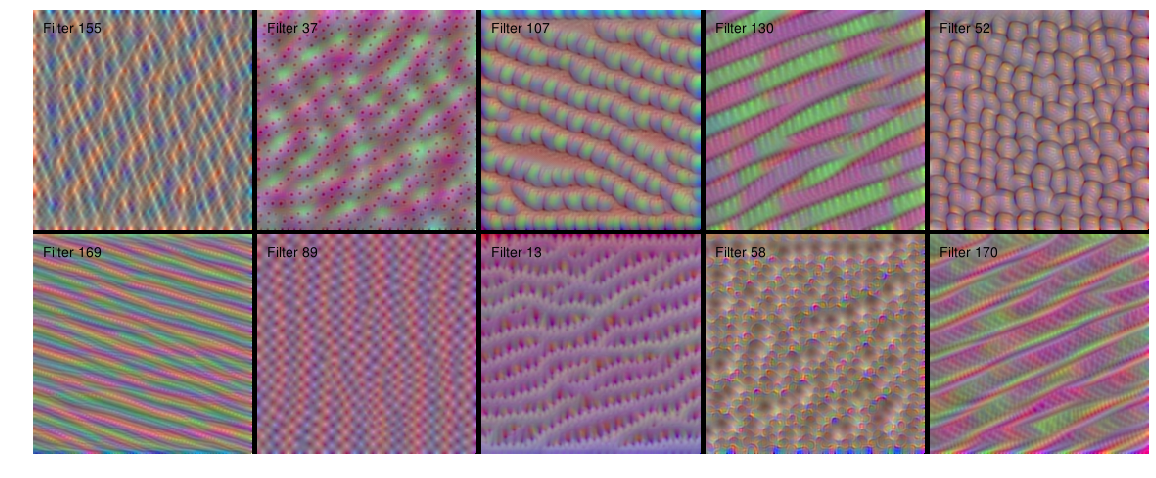

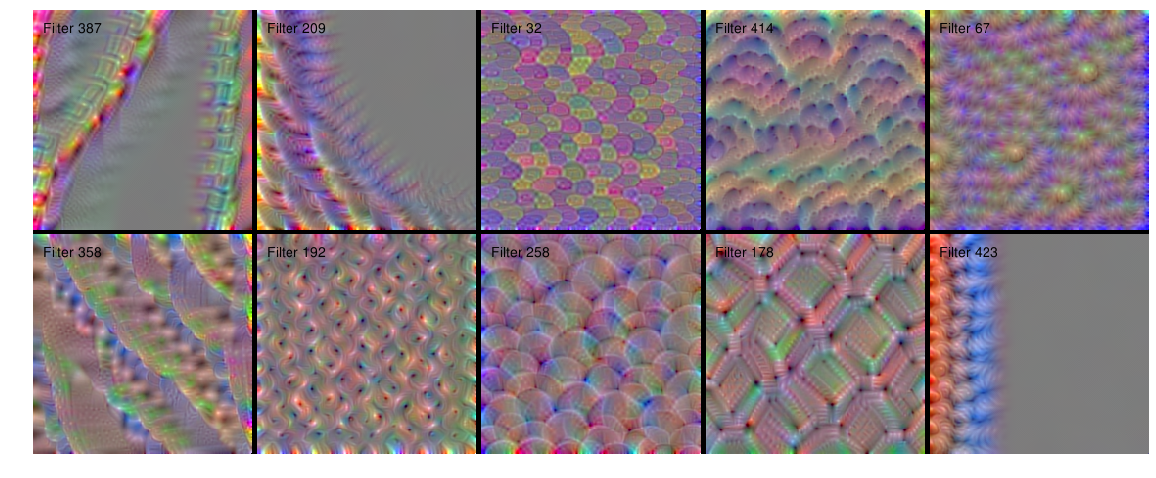

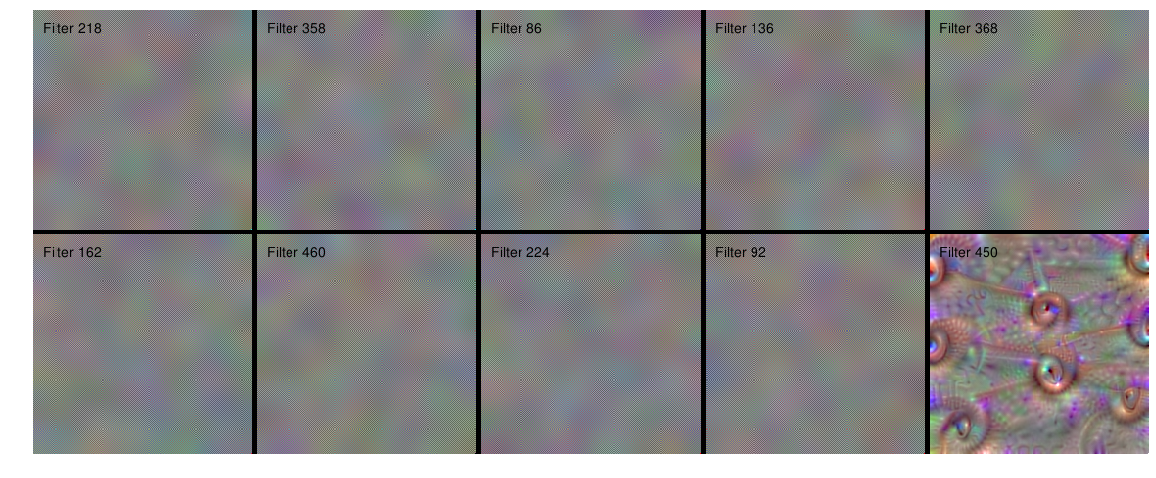

In [18]:
from vis.visualization import get_num_filters

selected_indices = []
for layer_name in ['block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']:
    layer_idx = utils.find_layer_idx(model, layer_name)

    # Visualize 10 random filters in this layer.
    filters = np.random.permutation(get_num_filters(model.layers[layer_idx]))[:10]
    selected_indices.append(filters)

    # Generate input image for each filter.
    vis_images = []
    for idx in filters:
        img = visualize_activation(model, layer_idx, filter_indices=idx)

        # Utility to overlay text on image.
        img = utils.draw_text(img, 'Filter {}'.format(idx))    
        vis_images.append(img)

    # Generate stitched image palette with 5 cols so we get 2 rows.
    stitched = utils.stitch_images(vis_images, cols=5)    
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(stitched)
    plt.show()

The low-level features were abstracted to construct complex, high-level features in the deeper convolutional layers.

In details, in block2_conv2, the filters begin to learn feature of edge information, direction, etc. However, the feature patterns are still quite simple without too much specific objects displayed. In block3_conv3, the patterns become more complex with more kinds of shapes. Not just points and stripes, but circles and polygons have emerged. In layer block4_conv3, the partterns become more intricately and colourfully piled up, with different sorts of overlap, stack and duplicate. Here part of the filters have suffered from unconvergence. In the last convolutional layer block5_conv3, unconvergence has become a serious problem. We would deal with this problem on the following.

# Visualization of unconverged layer

From the visualization shown above, we notice that some of the filters in block5_conv3 failed to converge.
This is usually because regularization losses (total variation and LP norm) are overtaking activation maximization loss.
(Ref to https://arxiv.org/pdf/1804.11191.pdf)
We could set Verbose to TRUE to have a look.

According to the user documents of keras-vis, we have several options to ecourage convergence if unconvergence happens: (Ref to https://raghakot.github.io/keras-vis/vis.visualization/#visualize_activation)
* 1.Different regularization weights.
* 2.Increase number of iterations.
* 3.Add Jitter input_modifier.
* 4.Try with 0 regularization weights, generate a converged image and use that as seed_input with regularization enabled.

First move: we add jitter and disable total variation.

Adding jitter would bring us some small improvement.

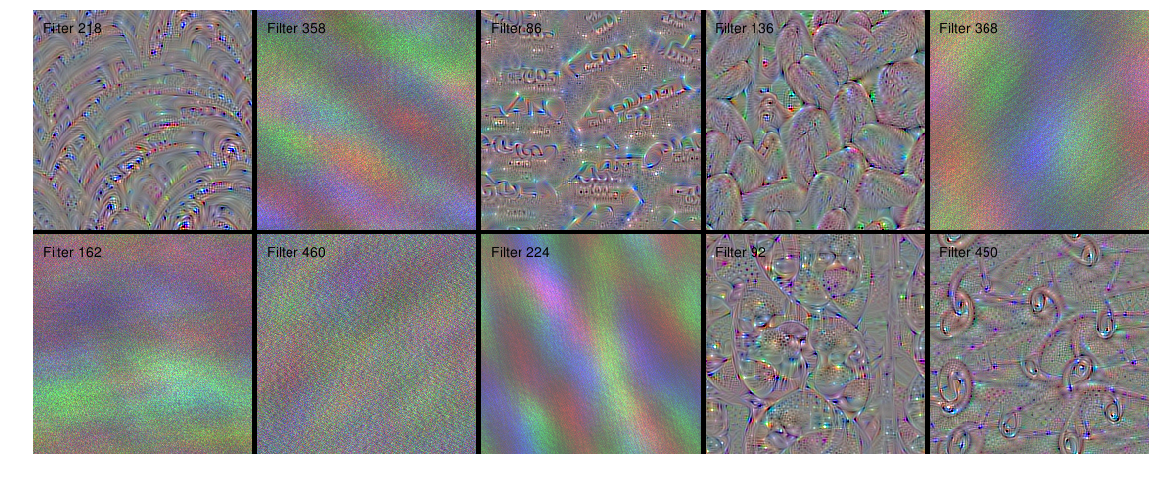

In [27]:
from vis.input_modifiers import Jitter
layer_idx = utils.find_layer_idx(model, 'block5_conv3')

# We need to select the same random filters in order to compare the results.
filters = selected_indices[-1]
selected_indices.append(filters)

# Generate input image for each filter.
vis_images = []
for idx in filters:
    # We will jitter 5% relative to the image size.
    img = visualize_activation(model, layer_idx, filter_indices=idx, 
                               tv_weight=0.,
                               input_modifiers=[Jitter(0.05)])

    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 5 cols so we get 2 rows.
stitched = utils.stitch_images(vis_images, cols=5)    
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(stitched)
plt.show()

Second move: We take a specific output from here and use it as a seed_input with total_variation enabled, making further improvement based on previous work.

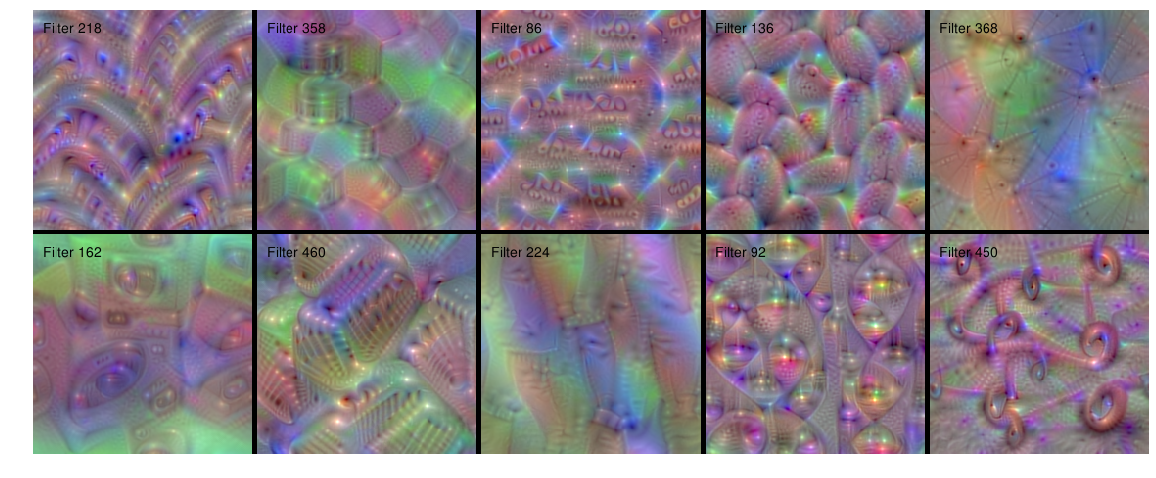

In [28]:
# Generate input image for each filter.
new_vis_images = []
for i, idx in enumerate(filters):
    # We will seed with optimized image this time.
    img = visualize_activation(model, layer_idx, filter_indices=idx, 
                               seed_input=vis_images[i],
                               input_modifiers=[Jitter(0.05)])
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    new_vis_images.append(img)

# Generate stitched image palette with 5 cols so we get 2 rows.
stitched = utils.stitch_images(new_vis_images, cols=5)    
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(stitched)
plt.show()

As we can see here, the visualizations have converged very well without increasing iterations. Compared to previous visualizations which fail to show any patterns or textures, the improvement here is very significant.

In the highest convolutional layer (block5_conv3), we start to recognize textures similar to those found in objects of training images such as feathers, eyes, polygons, etc. However, the features learned here are still not close to "figures" in the meaninng of human sense.

If we would like to view the final classification decision makers, we should view the last layer "prediction", which contains 1000 categories. In the prediction layer, we definitely would be able to use our eyes to recoginize quite more accurate textures corresponding to their categories just as we did for 3-layer CNN model trained by MNIST in the previous chapter.

Up to now, the whole work above reveals some basic visualizations of filters for a typical and sophisticated CNN model, which is both complicated on model architecture as well as on training dataset. Apart from that, we succeed to deal with unconvergence problem.

In conclusion, the filters of CNN model have learn two main points: first, they understand a decomposition of their visual input space as a hierarchical-modular network of convolution filters; second, they understand a probabilitistic mapping between certain combinations of these filters and a set of arbitrary labels. But naturally, we can not qualify this method of learning as "seeing" in human sense.